In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('CreditScore.csv')
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [7]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the `default` variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variab* `le - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* `seniority`
* `time`
* `income`
* `debt`

## Question 2

Use only: `['seniority', 'income', 'assets', 'records', 'job', 'home']`

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.512
* 0.612
* 0.712
* 0.812

In [10]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int32
dtype: object

In [11]:
numerical = ['seniority', 'income', 'assets']
categorical = ['job', 'records']

In [12]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
status_dec = (y_pred >= 0.5)
(y_val == status_dec).mean()

0.7631874298540965

#### Confusion Table

In [14]:
actual_pos = (y_val == 1)
actual_neg = (y_val == 0)

In [15]:
t = 0.5
pred_pos = (y_pred >= t)
pred_neg = (y_pred < t)

In [16]:
tp = (pred_pos & actual_pos).sum()
tn = (pred_neg & actual_neg).sum()

In [17]:
fp = (pred_pos & actual_neg).sum()
fn = (pred_neg & actual_pos).sum()

In [18]:
fp, fn

(66, 145)

In [19]:
tp, tn

(101, 579)

In [20]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[579,  66],
       [145, 101]])

In [21]:
(confusion_matrix / confusion_matrix.sum()).round(3)

array([[0.65 , 0.074],
       [0.163, 0.113]])

In [22]:
roc_auc_score(y_val, y_pred)

0.7977973151824541

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [23]:
r = tp / (tp + fn)
r

0.4105691056910569

In [24]:
p = tp / (tp + fp)
p

0.6047904191616766

In [25]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' %(t, score))
    scores.append(score)

0.00 0.276
0.01 0.288
0.02 0.302
0.03 0.323
0.04 0.347
0.05 0.373
0.06 0.400
0.07 0.418
0.08 0.441
0.09 0.458
0.10 0.485
0.11 0.504
0.12 0.524
0.13 0.540
0.14 0.556
0.15 0.563
0.16 0.582
0.17 0.602
0.18 0.611
0.19 0.623
0.20 0.639
0.21 0.650
0.22 0.666
0.23 0.677
0.24 0.695
0.25 0.701
0.26 0.709
0.27 0.715
0.28 0.717
0.29 0.728
0.30 0.738
0.31 0.746
0.32 0.751
0.33 0.753
0.34 0.754
0.35 0.762
0.36 0.767
0.37 0.764
0.38 0.771
0.39 0.778
0.40 0.779
0.41 0.776
0.42 0.777
0.43 0.779
0.44 0.776
0.45 0.768
0.46 0.772
0.47 0.773
0.48 0.769
0.49 0.764
0.50 0.763
0.51 0.759
0.52 0.761
0.53 0.761
0.54 0.763
0.55 0.761
0.56 0.758
0.57 0.761
0.58 0.762
0.59 0.762
0.60 0.760
0.61 0.755
0.62 0.755
0.63 0.758
0.64 0.750
0.65 0.750
0.66 0.750
0.67 0.746
0.68 0.744
0.69 0.744
0.70 0.742
0.71 0.741
0.72 0.741
0.73 0.741
0.74 0.741
0.75 0.740
0.76 0.740
0.77 0.737
0.78 0.735
0.79 0.734
0.80 0.733
0.81 0.734
0.82 0.734
0.83 0.734
0.84 0.734
0.85 0.735
0.86 0.734
0.87 0.733
0.88 0.731
0.89 0.727
0.90 0.724

In [26]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # evaluate actual_negative and actual_positive
    # confusion table
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [27]:
scores

[(0.0, 246, 645, 0, 0),
 (0.01, 246, 634, 0, 11),
 (0.02, 244, 620, 2, 25),
 (0.03, 242, 599, 4, 46),
 (0.04, 240, 576, 6, 69),
 (0.05, 238, 551, 8, 94),
 (0.06, 236, 525, 10, 120),
 (0.07, 236, 509, 10, 136),
 (0.08, 235, 487, 11, 158),
 (0.09, 232, 469, 14, 176),
 (0.1, 232, 445, 14, 200),
 (0.11, 231, 427, 15, 218),
 (0.12, 230, 408, 16, 237),
 (0.13, 230, 394, 16, 251),
 (0.14, 229, 379, 17, 266),
 (0.15, 227, 370, 19, 275),
 (0.16, 224, 350, 22, 295),
 (0.17, 223, 332, 23, 313),
 (0.18, 219, 320, 27, 325),
 (0.19, 217, 307, 29, 338),
 (0.2, 215, 291, 31, 354),
 (0.21, 212, 278, 34, 367),
 (0.22, 210, 262, 36, 383),
 (0.23, 207, 249, 39, 396),
 (0.24, 207, 233, 39, 412),
 (0.25, 204, 224, 42, 421),
 (0.26, 200, 213, 46, 432),
 (0.27, 194, 202, 52, 443),
 (0.28, 190, 196, 56, 449),
 (0.29, 185, 181, 61, 464),
 (0.3, 181, 168, 65, 477),
 (0.31, 176, 156, 70, 489),
 (0.32, 174, 150, 72, 495),
 (0.33, 168, 142, 78, 503),
 (0.34, 166, 139, 80, 506),
 (0.35000000000000003, 164, 130, 82, 

In [28]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,246,645,0,0
1,0.01,246,634,0,11
2,0.02,244,620,2,25
3,0.03,242,599,4,46
4,0.04,240,576,6,69


In [29]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [30]:
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,246,645,0,0,1.00000,1.000000
1,0.01,246,634,0,11,1.00000,0.982946
2,0.02,244,620,2,25,0.99187,0.961240
3,0.03,242,599,4,46,0.98374,0.928682
4,0.04,240,576,6,69,0.97561,0.893023


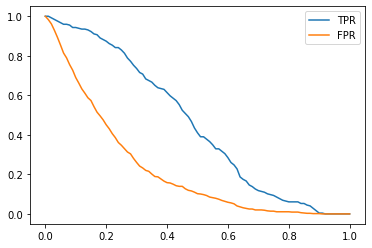

In [31]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()
plt.show()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

`F1 = 2 * P * R / (P + R)`

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.1
* 0.3
* 0.5
* 0.7

In [32]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # evaluate actual_negative and actual_positive
    # confusion table
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = (2 * p * r) / (p + r)
    
    scores.append((t, tp, fp, fn, tn, f1))

C:\Users\njtol\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [33]:
scores

[(0.0, 246, 645, 0, 0, 0.43271767810026385),
 (0.01, 246, 634, 0, 11, 0.4369449378330373),
 (0.02, 244, 620, 2, 25, 0.43963963963963965),
 (0.03, 242, 599, 4, 46, 0.4452621895124196),
 (0.04, 240, 576, 6, 69, 0.45197740112994345),
 (0.05, 238, 551, 8, 94, 0.4599033816425121),
 (0.06, 236, 525, 10, 120, 0.4687189672293942),
 (0.07, 236, 509, 10, 136, 0.4762865792129163),
 (0.08, 235, 487, 11, 158, 0.4855371900826447),
 (0.09, 232, 469, 14, 176, 0.4899683210137276),
 (0.1, 232, 445, 14, 200, 0.5027085590465872),
 (0.11, 231, 427, 15, 218, 0.5110619469026549),
 (0.12, 230, 408, 16, 237, 0.5203619909502263),
 (0.13, 230, 394, 16, 251, 0.5287356321839081),
 (0.14, 229, 379, 17, 266, 0.5362997658079625),
 (0.15, 227, 370, 19, 275, 0.5385527876631079),
 (0.16, 224, 350, 22, 295, 0.5463414634146342),
 (0.17, 223, 332, 23, 313, 0.5568039950062422),
 (0.18, 219, 320, 27, 325, 0.5579617834394904),
 (0.19, 217, 307, 29, 338, 0.5636363636363636),
 (0.2, 215, 291, 31, 354, 0.5718085106382979),
 (0.2

In [34]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'f1']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

,threshold,tp,fp,fn,tn,f1
0,0.00,246,645,0,0,0.432718
1,0.01,246,634,0,11,0.436945
2,0.02,244,620,2,25,0.439640
3,0.03,242,599,4,46,0.445262
4,0.04,240,576,6,69,0.451977


Answer is 0.3

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`


* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

* 0.001
* 0.014
* 0.09
* 0.14

In [35]:
def train(df_train, y):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)
    
    return dv, model

In [36]:
dv, model = train(df_train, y_train)

In [37]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    # create feature matrix
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [38]:
y_pred = predict(df_val, dv, model)

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [42]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [43]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [44]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [45]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.800 +- 0.018


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 1
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`

In [47]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [48]:
dv, model = train(df_train, y_train, C=0.001)

In [49]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [50]:
y_pred = predict(df_val, dv, model)

In [52]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.763 +- 0.009
C=0.01 0.799 +- 0.014
C=0.1 0.803 +- 0.016
C=0.5 0.802 +- 0.017
C=1 0.803 +- 0.016
C=5 0.803 +- 0.016
C=10 0.802 +- 0.017

